In [1]:
from PyUoI.UoINMF import UoINMF
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from scipy.optimize import curve_fit
from scipy.stats import norm, sem
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from pylatex import Document, Section, Subsection, Command
from pylatex import Document, Section, Figure, SubFigure, NoEscape
from pylatex.utils import italic, NoEscape
from scipy.stats import norm, sem

In [2]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [3]:
def statistics(matrix):
    mat = np.matrix(matrix)
    i = mat.shape[0]-2
    tp = mat[i,i]
    tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
    fp = mat[:,i].sum() - mat[i,i]
    fn = mat[i,:].sum() - mat[i,i]
    return tp, tn, fp, fn

In [4]:
def true_neg_rate(tn, fp):
    return tn/(tn+fp)

def true_pos_rate(tp, fn):
    return tp/(tp+fn)

def false_neg_rate(fn, tp):
    return fn/(fn+tp)
    
def false_pos_rate(fp, tn):
    return fp/(fp+tn)
    
def precision(tp, fp):
    return tp/(tp+fp)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp + fp + fn)

In [6]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

[[[  0.           0.11111111   0.55555556 ...,   0.66666667   0.66666667
     1.        ]
  [  0.           0.11111111   0.66666667 ...,   1.11111111   0.88888889
     1.22222222]
  [  0.           0.11111111   0.66666667 ...,   1.33333333   1.11111111
     1.66666667]
  ..., 
  [  0.           1.           2.         ...,  30.22222222  35.44444444
     7.77777778]
  [  0.           1.           2.         ...,  30.77777778  36.
     7.88888889]
  [  0.           1.           2.         ...,  31.44444444  36.66666667
     8.        ]]

 [[  0.           0.           0.22222222 ...,   0.66666667   0.66666667
     0.66666667]
  [  0.           0.11111111   0.44444444 ...,   0.88888889   0.88888889
     0.77777778]
  [  0.           0.33333333   0.55555556 ...,   1.44444444   1.44444444
     1.44444444]
  ..., 
  [  0.           1.           2.         ...,  29.          39.44444444
     9.66666667]
  [  0.           1.           2.         ...,  29.22222222  39.88888889
     9.77777778]


[[[  0.           0.11111111   0.55555556 ...,   0.66666667   0.66666667
     1.        ]
  [  0.           0.11111111   0.66666667 ...,   1.11111111   0.88888889
     1.22222222]
  [  0.           0.11111111   0.66666667 ...,   1.33333333   1.11111111
     1.66666667]
  ..., 
  [  0.           1.           2.         ...,  30.22222222  35.44444444
     7.77777778]
  [  0.           1.           2.         ...,  30.77777778  36.
     7.88888889]
  [  0.           1.           2.         ...,  31.44444444  36.66666667
     8.        ]]

 [[  0.           0.           0.22222222 ...,   0.66666667   0.66666667
     0.66666667]
  [  0.           0.11111111   0.44444444 ...,   0.88888889   0.88888889
     0.77777778]
  [  0.           0.33333333   0.55555556 ...,   1.44444444   1.44444444
     1.44444444]
  ..., 
  [  0.           1.           2.         ...,  29.          39.44444444
     9.66666667]
  [  0.           1.           2.         ...,  29.22222222  39.88888889
     9.77777778]


KeyboardInterrupt: 

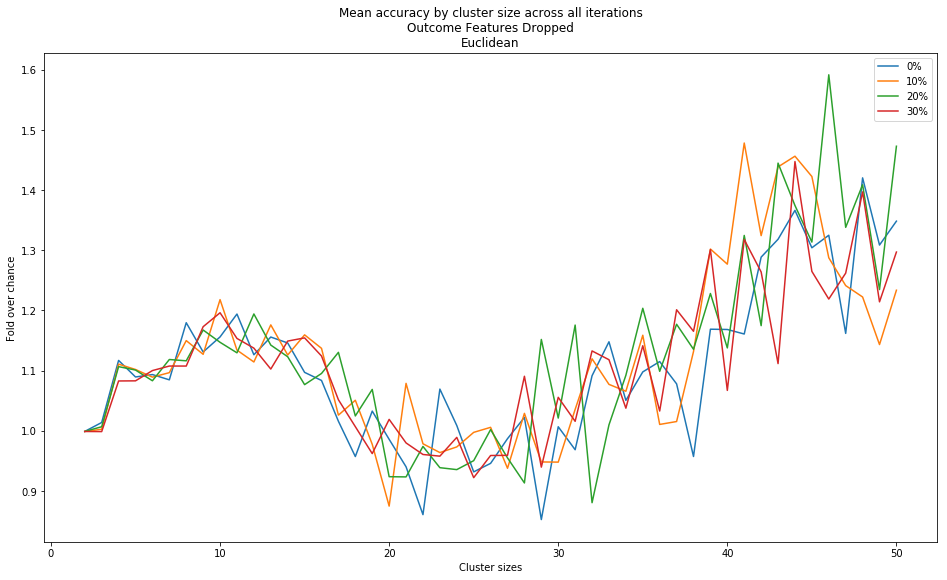

In [17]:
percent = [0,10,20,30,40,50,60,70,80,90]
percent2=[0,50,90]

for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/features_dropped/oc_features_dropped/oc_features_dropped_opp_result_{}.h5'.format(p)
    f = h5py.File(path, 'r')
    predictions = f['score'][:].mean(axis=1)
    norm_predictions = f['norm_score'][:].mean(axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = f['clusters'][:].mean(axis=1)
    print(labels)
    fold_over_chance = np.zeros((len(cluster_sizes), 50))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels)
        norm_all50mat = conf_alliter(c, norm_predictions, labels)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
    fold_over_chance = np.mean(fold_over_chance, axis=1)
    
    plt.rcParams["figure.figsize"] = [16,9]
    cmap = plt.get_cmap("tab10")
    plt.plot(cluster_sizes, fold_over_chance, label='{}%'.format(p), color = cmap(ii))
    
    plt.title("Mean accuracy by cluster size across all iterations\nOutcome Features Dropped\nEuclidean")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


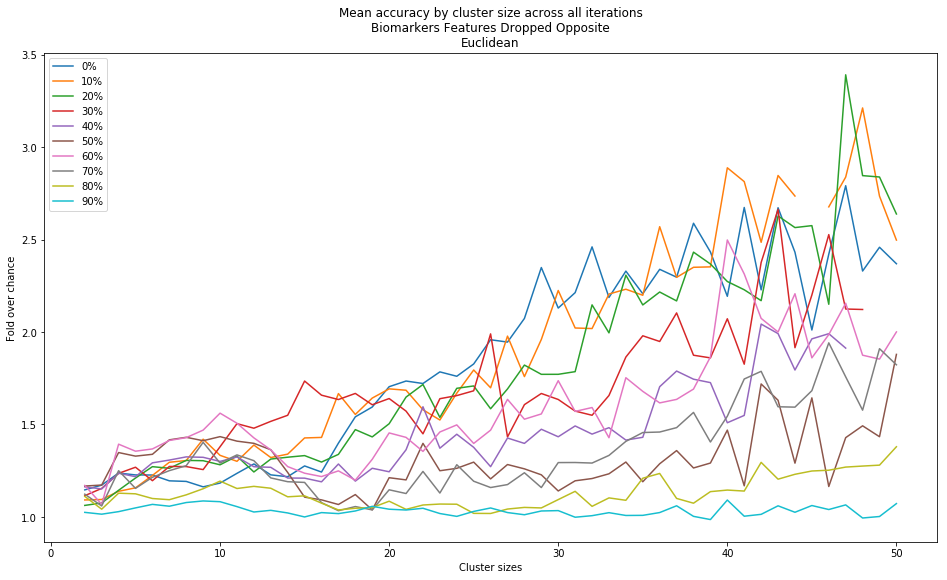

In [18]:
percent = [0,10,20,30,40,50,60,70,80,90]
percent2=[0,50,90]

for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/features_dropped/bm_features_dropped/bm_features_dropped_opp_result_{}.h5'.format(p)
    f = h5py.File(path, 'r')
    predictions = f['score'][:]
    norm_predictions = f['norm_score'][:]
    cluster_sizes = f['cluster_sizes'][:]
    labels = f['clusters'][:]    
    fold_over_chance = np.zeros((len(cluster_sizes), 50))
    
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels)
        norm_all50mat = conf_alliter(c, norm_predictions, labels)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
    fold_over_chance = np.mean(fold_over_chance, axis=1)
    
    plt.rcParams["figure.figsize"] = [16,9]
    cmap = plt.get_cmap("tab10")
    plt.plot(cluster_sizes, fold_over_chance, label='{}%'.format(p), color = cmap(ii))
    
    plt.title("Mean accuracy by cluster size across all iterations\nBiomarkers Features Dropped Opposite\nEuclidean")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/bm_dropped_opp_plot.pdf')